# Transfer learning on Images

Transfer Learning
-----
Transfer learning is a powerful technique in deep learning where a model developed for a specific task is reused as the starting point for a model on a second task. This approach is especially beneficial in scenarios where you have a limited amount of data for the second task, but you can leverage a large and diverse dataset from a related task that the model was originally trained on.

### Key Concepts of Transfer Learning

1. **Pre-trained Models**: In many applications of transfer learning, models are initially trained on a large dataset (like ImageNet for image tasks or a large corpus of text for language models). This initial training develops a robust representation that can capture general features of the input space.

2. **Feature Transfer**: After the model has been pre-trained, it can be adapted to a new but related problem. This usually involves tweaking the model slightly to make it more suitable for the new task. Often, this means changing the final layers of the model that make the actual predictions.

3. **Fine-tuning**: Instead of training a new model from scratch, fine-tuning involves continuing the training of the pre-trained model on the new dataset. Typically, the learning rate used during fine-tuning is much lower than that used in initial training, to make smaller adjustments to the weights.

4. **Freezing Layers**: In many cases, the early layers of the neural network (which capture universal features like edges and textures in images, or common word usage patterns in text) are kept frozen, meaning their weights are not updated during training. Only the deeper layers are trained to adapt to the specifics of the new task.

### Benefits of Transfer Learning

- **Efficiency**: Training a model from scratch can be computationally expensive and time-consuming. Using transfer learning can significantly reduce both, as the model has already learned a considerable amount from the initial task.
- **Performance**: For many tasks, especially those where the available data is limited, transfer learning can lead to better performance than a model trained from scratch.
- **Generalization**: Pre-trained models have been exposed to a broader range of data, allowing them to generalize better in many cases.

### Use Cases

- **Computer Vision**: Transfer learning is widely used in computer vision, from simple classification tasks to more complex object detection and segmentation tasks.
- **Natural Language Processing (NLP)**: Models like BERT and GPT are often used as the basis for various NLP tasks, including translation, text classification, and sentiment analysis.
- **Speech Recognition**: Transfer learning can help adapt a general speech recognition system to understand dialects or accents by fine-tuning it with examples from those specific speech characteristics.

Overall, transfer learning has been a game-changer in the field of deep learning, allowing for rapid deployment of sophisticated models that build on prior knowledge and expertise.

In [1]:
import numpy as np
import cv2

import PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub  ## Shall be installed separately 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-05-03 17:53:55.858315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 17:53:55.858437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 17:53:56.026926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf 
version_fn = getattr(tf.keras, "version", None)
print("TF Version: " + tf.__version__)
print("TF Keras Version: " + version_fn())

TF Version: 2.15.0
TF Keras Version: 3.2.1


In the following, we have `downgrade to the older version of Keras`. Currently, 3rd of May, Keras version in Kaggle Notebook is 3.2.1 which is incompatible with the `tensorflow_hub` library. This library uses Keras V2.x. To solve this issue, we install the `tf_keras` which contains the Keras v2.x. 

> The code before fixing it is as below. This code is completely copied and paste from [here](https://arc.net/l/quote/swfilcsv) and it simply uses the tensorflow which has the keras version 3. 
```python
m = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-classification/4", output_shape=[1001])
])
m.build([None, 224, 224, 3])  # Batch input shape.
```

> The related error message after running the code is:
```Python
ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7a8abc1f4eb0> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)
```

I found the solution to this issue at [Github](https://arc.net/l/quote/kqvqxwzn). Which simply suggests to install the older version of the Keras, which the `Tensorflow_hub` is compatible with. To do so, I have run the following command:

In [3]:
!pip install tf_keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
import tf_keras as tfk

Now, we continue and we will use `tfk` wherever we want to use `hub` library.

# First Part - Importing and Using Pre-Trained model

Tensorflow Hub
-----
[TensorFlow Hub](https://www.tensorflow.org/hub/overview#:~:text=TensorFlow%20Hub%20is%20an%20open,is%20open%20to%20community%20contributors.) is an open repository and library for reusable machine learning. The [tfhub.dev](https://tfhub.dev/) repository provides many pre-trained models: text embeddings, image classification models, TF.js/TFLite models and much more. The repository is open to community contributors.

The [`tensorflow_hub`](https://github.com/tensorflow/hub) library lets you download and reuse them in your TensorFlow program with a minimum amount of code.

Let's try [*mobilenet_v2*](https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-classification) model. According to the [description](https://arc.net/l/quote/ehiewkuo) in the `Usage` section, we need to run the below code to get access to it directly. 

In [5]:
m = tfk.Sequential([  ## Note that we have used tfk which contains the Keras version 3
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-classification/4", output_shape=[1001])
])

m.build([None, 224, 224, 3])  # Batch input shape.

Attaching model 'google/mobilenet-v2/tensorflow2/tf2-preview-classification/4' to your Kaggle notebook...


In the next cell, we want to import the labels of this Model. According to its [description](https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/tf2-preview-classification/4?tfhub-redirect=true), it has *1001* classes. We import them and add them to a list. 

In [6]:
labels = []
with open("/kaggle/input/imagenetlabels/ImageNetLabels.txt", "r") as labelsFile:
    labels = labelsFile.read().splitlines()

print(labels[:5], len(labels))

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark'] 1001


In the next, I have downloaded a random image from the WWW and import it here. I want to use the imported Pre-trained model to classify this image. 

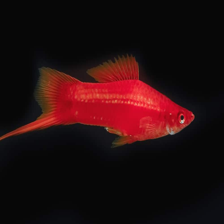

In [7]:
## Resized it as the main images are 224 by 224
tst_img = Image.open("/kaggle/input/image1/fish/red_fish5.jpeg").resize((224, 224))  
tst_img

Let's normalize it as always:

In [8]:
tst_img = np.array(tst_img)/255.0
tst_img.shape

(224, 224, 3)

Now, since it is only one image, we need to add 1 more dimension representing the number of data which is here one as we want to test only this image. Hence, we do as follow:

In [9]:
tst_img[np.newaxis, ...].shape

(1, 224, 224, 3)

Let's do the prediction on the image. Our model name is `m`:

In [10]:
result = m.predict(tst_img[np.newaxis, ...])
result.shape

1/1 [==============================] - 12s 12s/step


(1, 1001)

The `result` variable has only one vector of probability as we gave only one image and we have 1001 classes. So, this is a vector of probability of each classes that the input data can belong to. Obviously, the right class must be the one with the highest probability.  

To find this in the list of 1001 values we do the following.

- Don't forget that `argmax()` returns the index of the value with the higher value:

In [11]:
predicted_label_index = np.argmax(result)  ## Getting the index of the maximum value
labels[predicted_label_index]  ## The index of this value is exactly the index of the class
                               ## So, we use the `labels` list that we have previously defined

'goldfish'

We see that in this case the prediction is correct, also the model is not trained again.

# Second Part - Training the Pre-trained model 
Next, we want to use this already trained model, to train it on another new dataset. 

## Loading Flowers Dataset
Here, we want to import Flower Dataset from the Google/Tensorflow repository. 

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Total number of images is:  3670 



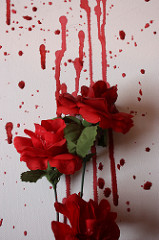

In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total number of images is: ", image_count, '\n')

roses = list(data_dir.glob('roses/*'))

PIL.Image.open(str(roses[1]))

### Reading flowers images from directory

In [14]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

Creating corresponding labels:

In [15]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [16]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(250, 320, 3)

By taking a look at their dimensions, we see that they are not the same as the pre-trained model's. Hence, we resize them to make them the same.

In [17]:
cv2.resize(img, (224, 224)).shape

(224, 224, 3)

In the next cell, we are creating data `X` and their corresponding class `y`. We will then split them and make them ready for the traing section. 

In [18]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

X = np.array(X)
y = np.array(y)
X.shape, y.shape

((3670, 224, 224, 3), (3670,))

### Train/Test split

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Preprocessing: scale images

In [20]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Let's see a prediction again before starting our training:

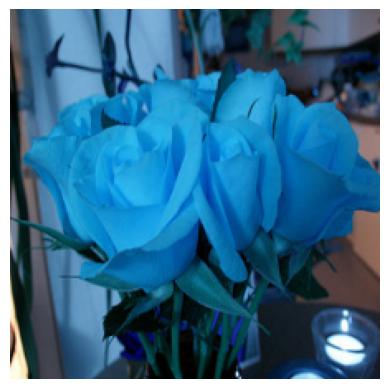

In [21]:
plt.axis('off')
plt.imshow(X[0])

In [22]:
predicted = m.predict(X[0][np.newaxis, ...])
predicted_index = np.argmax(predicted, axis=1)
labels[predicted_index[0]]

1/1 [==============================] - 1s 580ms/step


'shower curtain'

In [23]:
m.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


m.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 13s 75ms/step - loss: 8.8497 - acc: 0.0000e+00


[8.849686622619629, 0.0]

Very good accuracy :)

Forget it, let's Retrain it.

## Retraining the Pre-trained model

Here, again we are getting the direct link to the pre-trained model. Then, we are creating a new layer with it. 

In [24]:
pre_trained_model = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-classification/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    pre_trained_model, input_shape=(224, 224, 3), trainable=False)

Attaching model 'google/mobilenet-v2/tensorflow2/tf2-preview-classification/4' to your Kaggle notebook...


If you notice, in the below, we used `tfk` which has the older version of Keras which is compatible with the `tensorflow_hub`. 

In [25]:
model = tfk.Sequential([
  pretrained_model_without_top_layer,
  tfk.layers.Dense(5)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 3545275 (13.52 MB)
Trainable params: 5010 (19.57 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [26]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
 1/86 [..............................] - ETA: 13:22 - loss: 2.5445 - acc: 0.2188

I0000 00:00:1714758937.532532      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 [==============================] - 13s 37ms/step - loss: 0.7975 - acc: 0.7129
Epoch 2/5
86/86 [==============================] - 3s 37ms/step - loss: 0.4034 - acc: 0.8576
Epoch 3/5
86/86 [==============================] - 3s 37ms/step - loss: 0.3160 - acc: 0.8870
Epoch 4/5
86/86 [==============================] - 3s 37ms/step - loss: 0.2655 - acc: 0.9084
Epoch 5/5
86/86 [==============================] - 3s 37ms/step - loss: 0.2313 - acc: 0.9230


In [27]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 2s 38ms/step - loss: 0.4248 - acc: 0.8595


[0.424756795167923, 0.8594771027565002]

We have achieved a good accuracy. 